In [26]:
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import numpy as np
from scipy.signal import find_peaks

In [27]:
# insert measurement data for plotting

# Series 1
# offset = 250mV DC, amplitude = 200mVpp AC,, buffer=on, CH3
# measurement interval = 20 seconds
# d=3 > 1865 S/s  

x_series1 = [0.100,0.200,0.400,0.800,1.000,2.000,4.000,8.000,10.00,20.00,40.00] # Frequency points
y_series1 = [-27.9,-30.6,-34.7,-40.0,-41.8,-47.6,-53.5,-59.7,-61.6,-68.2,-76.9] # Magnitude in dBV

# Series 2
# offset = 250mV DC, amplitude = 200mVpp AC, with a voltage controlled current source where 1 V = 100nA, buffer=on, CH2
# measurement interval = 20 seconds
# d=3 > 1865 S/s  

x_series2 = [0.100,0.200,0.400,0.800,1.000,2.000,4.000,8.000,10.00,20.00,40.00,80.00,100.0,200.0,400.0,800.0] # Frequency points
y_series2 = [-28.6,-29.3,-30.1,-31.0,-31.3,-32.2,-33.0,-37.5,-33.9,-35.4,-37.3,-38.6,-38.2,-38.9,-38.8,-45.1] # Magnitude in dBV

# Series 3
# offset = 250mV DC, amplitude = 200mVpp AC, with a voltage controlled current source where 1V = 100nA into a photo diode bridge with 10 Mega Ohm resistors,
# buffer=on, CH2, measurement interval = 20 seconds
# d=3 > 1865 S/s  

x_series3 = [0.100,0.200,0.400,0.800,1.000,2.000,4.000,8.000,10.00,20.00,40.00,80.00,100.0,200.0,400.0,800.0] # Frequency points
y_series3 = [-36.8,-37.2,-37.7,-38.3,-38.4,-39.0,-39.5,-41.3,-44.9,-41.0,-43.4,-44.7,-44.6,-44.1,-44.5,-49.2] # Magnitude in dBV

In [28]:
data = np.loadtxt("/tmp/adc_data.csv") # reading in volts

print('n:{:>19d}'.format(len(data)))
print('median: {: .6e}'.format(np.median(data)))
print('mean:   {: .6e}'.format(np.mean(data)))
#print('max:    {: .6e}'.format(np.max(data)))
#print('min:    {: .6e}'.format(np.min(data)))
print('std:    {: .6e}'.format(np.std(data)))
print('p2p:    {: .6e}'.format(np.max(data)-np.min(data)))
#print(' 0.05%: {: .6e}'.format(np.percentile(data, 0.05)))
#print('99.95%: {: .6e}'.format(np.percentile(data,99.95)))
print('99.9%:  {: .6e}'.format(np.percentile(data,99.95)-np.percentile(data, 0.05))) 
#Should be equivalent to 6.6 x sigma or 6.6 x std, assuming a gaussian distribution.


n:            3353109
median: -2.641678e-03
mean:   -2.670623e-03
std:     1.507596e-03
p2p:     1.182765e-02
99.9%:   7.424207e-03


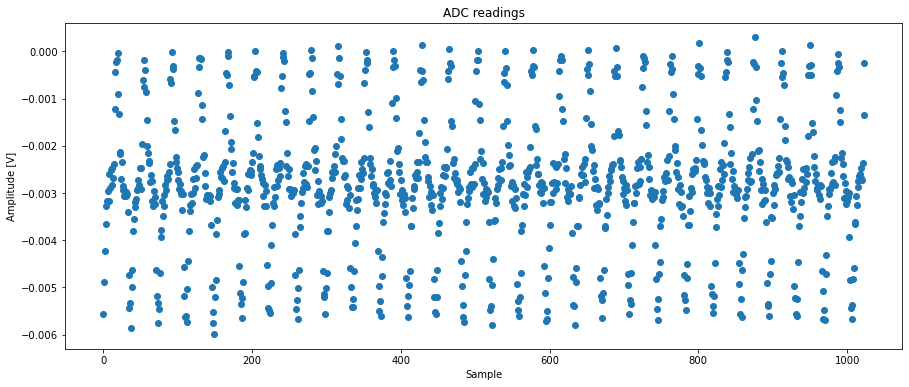

In [29]:
fig, axis = plt.subplots(figsize =(15, 6), facecolor=(1,1,1))

n = 2**10 # number of samples
s = 200 # starting sample
y = data[s:s+n]
axis.plot(y, 'o')

axis.set_ylabel('Amplitude [V]')
#axis.set_xlabel('Voltage [$\mu V$]')
axis.set_xlabel('Sample')
#axis.set_xlabel('Voltage [V]')
axis.set_title(r'ADC readings')
#plt.grid()
plt.savefig('adc_readings.png', bbox_inches='tight')
plt.show()

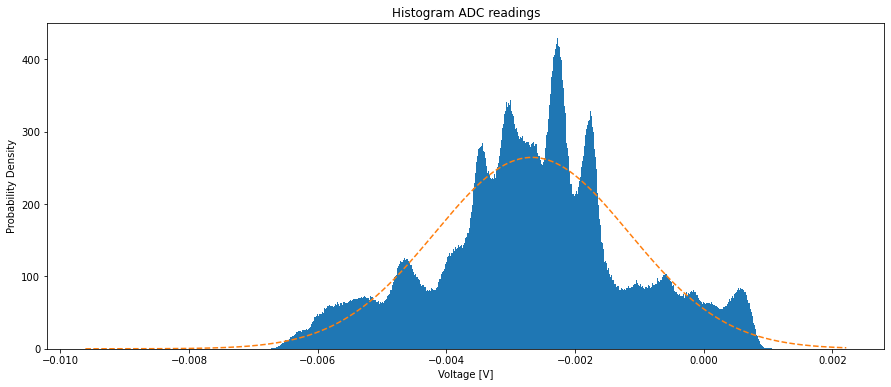

In [30]:
fig, axis = plt.subplots(figsize =(15, 6), facecolor=(1,1,1))

# create histogram
n, bins, patches = axis.hist(data, bins=1000, density=True)

# add a 'best fit' line
sigma = np.std(data)
mu = np.mean(data)
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
axis.plot(bins, y, '--')

axis.set_ylabel('Probability Density')
#axis.set_xlabel('Voltage [$\mu V$]')
axis.set_xlabel('Voltage [V]')
#axis.set_xlabel('Voltage [V]')
axis.set_title(r'Histogram ADC readings')
#plt.grid()
plt.savefig('histogram.png', bbox_inches='tight')
plt.show()

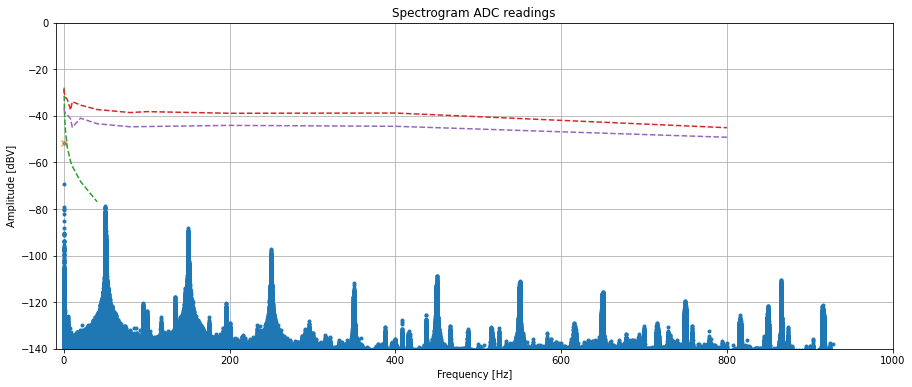

In [31]:
n = data.size
data_rate = 1865 # fill in the sample rate reported by the rpi_adc_stream command
time_step = 1./data_rate
freq_bins = np.fft.rfftfreq(n, d=time_step)
bin_width = 1/(data.size*time_step)
spectrum  = np.fft.rfft(data, norm='forward')

peaks, _ = find_peaks(np.abs(spectrum), height=0.001, distance=100) # find all peaks >= 2.0 uV^2/Hz
peaks.resize(peaks.size+1) # peaks consistently misses the first index (DC, 0 Hz) 
peaks.sort()               # by resizing and sorting this is corrected


fig, axis = plt.subplots(figsize =(15, 6), facecolor=(1,1,1))
#plt.plot(freqbins,20*np.log10(np.abs(fourier.real)), '.')
axis.plot(freq_bins, 20 * np.log10(np.abs(spectrum)), '.')
axis.plot(freq_bins[peaks], 20 * np.log10(np.abs(spectrum[peaks])), 'x' )
axis.plot(x_series1, y_series1, '--')
axis.plot(x_series2, y_series2, '--')
axis.plot(x_series3, y_series3, '--')
axis.set_xlabel('Frequency [Hz]')
#axis.set_ylabel('Amplitude [$\mu$V]')
axis.set_ylabel('Amplitude [dBV]')
axis.set_title(r'Spectrogram ADC readings')
plt.ylim(-140,0)
plt.xlim(-1e1,1e3)
plt.grid()
plt.savefig('spectrogram.png', bbox_inches='tight') 
plt.show()

In [32]:
print('DC         :','{: .5e}'.format(np.abs(spectrum[0])))
print('bin width  :','{: .5e}'.format(bin_width))
print('Vnoise_rms :','{: .5e}'.format((np.sum(np.abs(spectrum)*bin_width)-np.abs(spectrum[0]*bin_width))/2*1.57))
# Somehow just taking the total sum of the real part and dividing by 2 gives an accurate result for just gaussian noise. Why?
# it seems to work only for long measurement intervals > 100s? 1.57 is the correction factor for a 1 pole filter.
print('\nPeaks:\n')
print(' Freq. [Hz]    |  Ampl. [dBV]  ')
print(' --------------|-------------- ')
for i in peaks:
    print('{: .5e}'.format(freq_bins[i]),'  |','{: .5e}'.format(20 * np.log10(np.abs(spectrum[i]))))


DC         :  2.67062e-03
bin width  :  5.56200e-04
Vnoise_rms :  7.25953e-05

Peaks:

 Freq. [Hz]    |  Ampl. [dBV]  
 --------------|-------------- 
 0.00000e+00   | -5.14677e+01


(818, 2049)


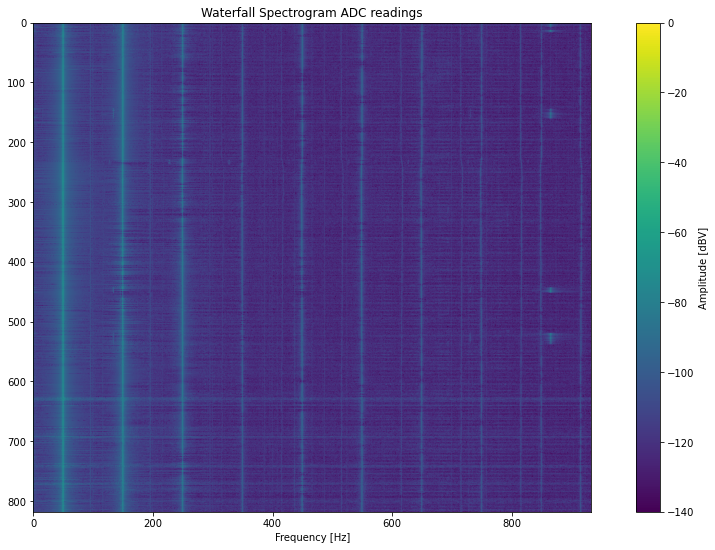

In [36]:

fig, axis = plt.subplots(figsize =(16, 9), facecolor=(1,1,1))
fft_points = (2 ** 12)
time_step = 1./data_rate
bin_width = 1/(data.size*time_step)
freq_bins = np.fft.rfftfreq(fft_points, d=time_step)
waterfall = np.empty((int(data.size/fft_points),int(fft_points/2)+1))
print(waterfall.shape)
for i in range(int(data.size/fft_points)):
    waterfall[i,] = 20 * np.log10(np.abs(np.fft.rfft(data[i*fft_points:(i+1)*fft_points], norm='forward')))
myplot = axis.imshow(waterfall, extent=[np.min(freq_bins),np.max(freq_bins),int(data.size/fft_points),0], vmin=-140,vmax=0) # vmin=10e-5,vmax=10e1, norm=colors.Normalize()
#fig.colorbar(myplot, label='Amplitude [$\mu$V]')
fig.colorbar(myplot, label='Amplitude [dBV]')
axis.set_xlabel('Frequency [Hz]')
axis.set_title(r'Waterfall Spectrogram ADC readings')
plt.savefig('waterfall.png', bbox_inches='tight')
plt.show()
